In [1]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from glob import glob
from tqdm import tqdm

In [2]:
# Set some display options
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 6)

# ---- Paths ----
DATA_DIR = "../data/yolo_dataset"
IMAGES_DIR = os.path.join(DATA_DIR, "images")
LABELS_DIR = os.path.join(DATA_DIR, "labels")
YAML_PATH = os.path.join(DATA_DIR, "dataset.yaml")

print("Data directory:", DATA_DIR)

# ---- Load YAML config ----
with open(YAML_PATH, "r") as f:
    data_yaml = yaml.safe_load(f)

print("\nDataset YAML Info:")
print(data_yaml)

# Class names and count
classes = data_yaml["names"]
num_classes = len(classes)
print(f"\nNumber of classes: {num_classes}")
print("Class list:", classes)

# ---- Collect label data ----
label_files = glob(os.path.join(LABELS_DIR, "**", "*.txt"), recursive=True)
print(f"\nTotal label files: {len(label_files)}")

all_labels = []

for file in tqdm(label_files, desc="Reading labels"):
    with open(file, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) >= 5:
                cls_id = int(parts[0])
                x_center, y_center, w, h = map(float, parts[1:5])
                all_labels.append({
                    "file": file,
                    "class_id": cls_id,
                    "class_name": classes[cls_id] if cls_id < len(classes) else "unknown",
                    "x_center": x_center,
                    "y_center": y_center,
                    "width": w,
                    "height": h
                })

df = pd.DataFrame(all_labels)
print("\nLabel dataframe shape:", df.shape)
df.head()


Data directory: ../data/yolo_dataset

Dataset YAML Info:
{'names': {0: 'cow', 1: 'person', 2: 'toilet', 3: 'scissors', 4: 'handbag', 5: 'tv', 6: 'chair', 7: 'couch', 8: 'laptop', 9: 'remote', 10: 'vase', 11: 'skis', 12: 'truck', 13: 'snowboard', 14: 'cake', 15: 'bowl', 16: 'skateboard', 17: 'car', 18: 'frisbee', 19: 'cell phone', 20: 'bicycle', 21: 'bench', 22: 'motorcycle', 23: 'cup', 24: 'pizza', 25: 'teddy bear', 26: 'dining table', 27: 'kite', 28: 'tie', 29: 'knife', 30: 'broccoli', 31: 'stop sign', 32: 'dog', 33: 'wine glass', 34: 'spoon', 35: 'fork', 36: 'bed', 37: 'cat', 38: 'sports ball', 39: 'baseball glove', 40: 'surfboard', 41: 'baseball bat', 42: 'bottle', 43: 'oven', 44: 'potted plant', 45: 'clock', 46: 'giraffe', 47: 'train', 48: 'parking meter', 49: 'fire hydrant', 50: 'bird', 51: 'boat', 52: 'sheep', 53: 'umbrella', 54: 'tennis racket', 55: 'sink', 56: 'toothbrush', 57: 'book', 58: 'backpack', 59: 'banana', 60: 'apple', 61: 'refrigerator', 62: 'donut', 63: 'microwave', 

Reading labels: 100%|██████████| 4955/4955 [00:00<00:00, 5694.07it/s]



Label dataframe shape: (36180, 7)


,file,class_id,class_name,x_center,y_center,width,height
0,../data/yolo_dataset/labels/val/000000420912.txt,51,boat,0.335195,0.643500,0.656953,0.381156
1,../data/yolo_dataset/labels/val/000000420912.txt,51,boat,0.701719,0.600484,0.202437,0.121594
2,../data/yolo_dataset/labels/val/000000420912.txt,1,person,0.458891,0.576070,0.203625,0.230547
3,../data/yolo_dataset/labels/val/000000420912.txt,42,bottle,0.583039,0.653852,0.050484,0.074328
4,../data/yolo_dataset/labels/val/000000420912.txt,51,boat,0.729844,0.597523,0.268500,0.064641


1. Class Distribution

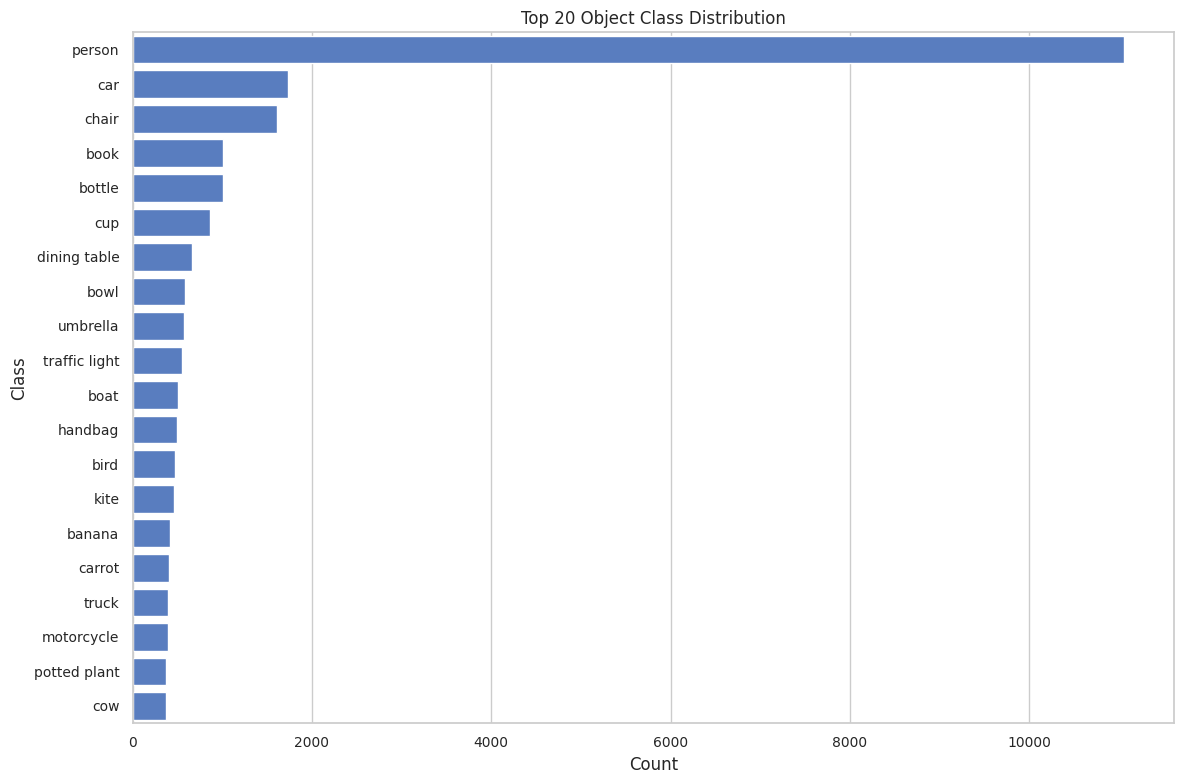

In [3]:
# ---- Class distribution (top 20 classes) ----
top_n = 20
class_counts = df["class_name"].value_counts().head(top_n)
plt.figure(figsize=(12, 8))
sns.countplot(
    y="class_name",
    data=df[df["class_name"].isin(class_counts.index)],
    order=class_counts.index
)
plt.title("Top 20 Object Class Distribution")
plt.xlabel("Count")
plt.ylabel("Class")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

2. Bounding box width and height distribution

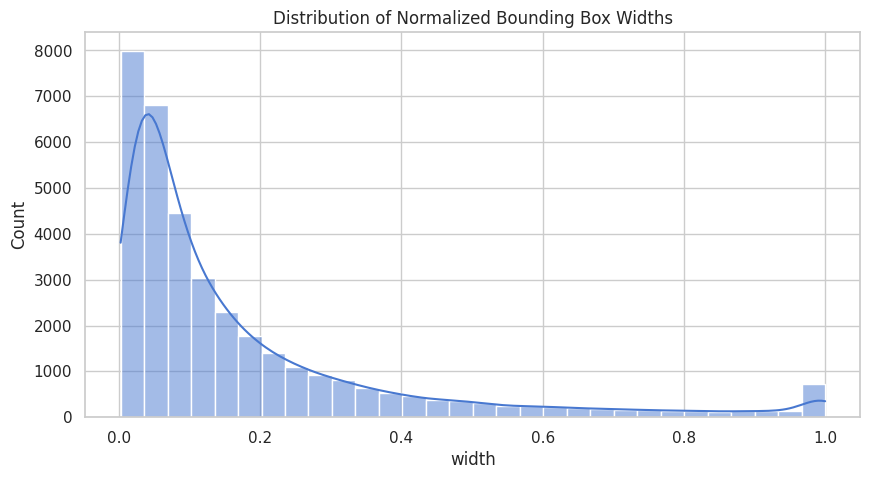

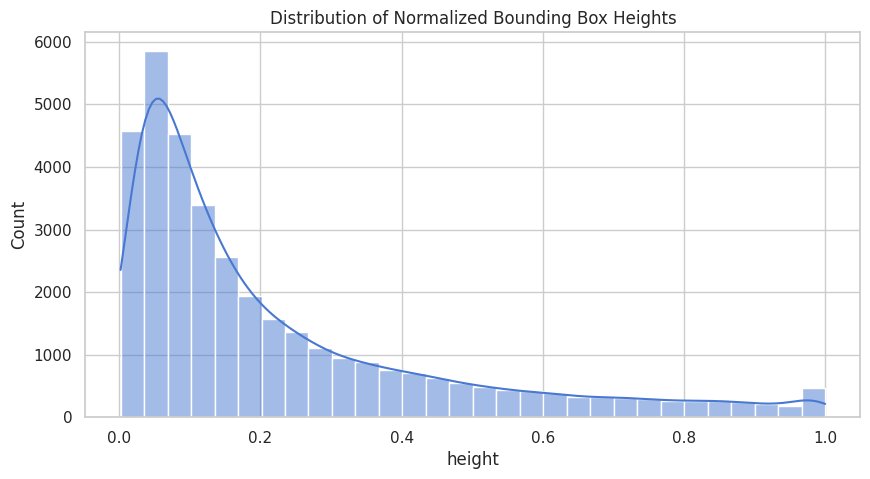

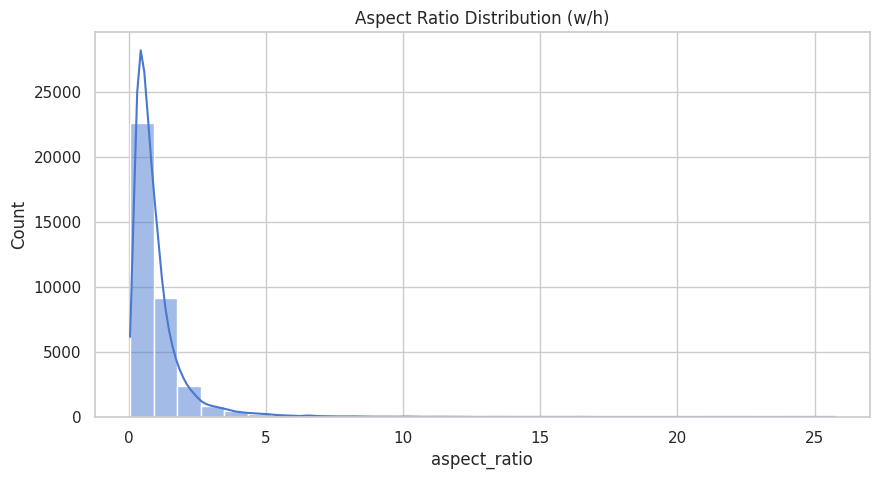

In [4]:
# Bounding box width and height distribution
plt.figure(figsize=(10,5))
sns.histplot(df["width"], bins=30, kde=True)
plt.title("Distribution of Normalized Bounding Box Widths")
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df["height"], bins=30, kde=True)
plt.title("Distribution of Normalized Bounding Box Heights")
plt.show()

# Aspect ratio
df["aspect_ratio"] = df["width"] / df["height"]
plt.figure(figsize=(10,5))
sns.histplot(df["aspect_ratio"], bins=30, kde=True)
plt.title("Aspect Ratio Distribution (w/h)")
plt.show()


3. Objects per Image

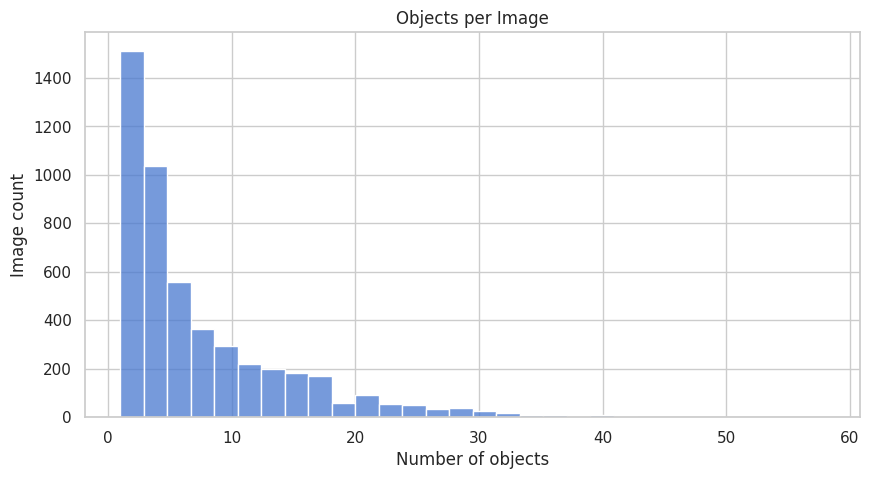

Average objects per image: 7.301715438950555


In [5]:
# Count how many objects per image
objects_per_image = df.groupby("file").size()
plt.figure(figsize=(10,5))
sns.histplot(objects_per_image, bins=30, kde=False)
plt.title("Objects per Image")
plt.xlabel("Number of objects")
plt.ylabel("Image count")
plt.show()

print("Average objects per image:", objects_per_image.mean())


4. Visualize Random Samples with Bounding Boxes

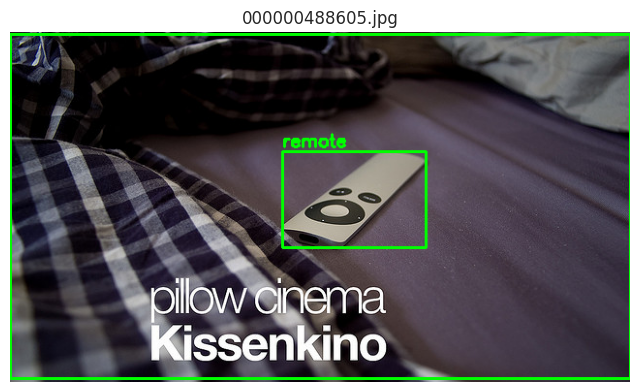

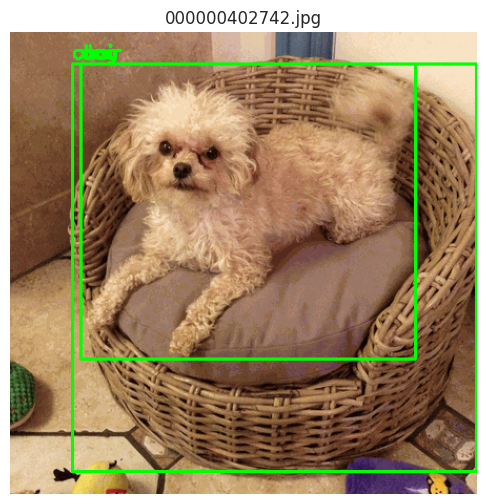

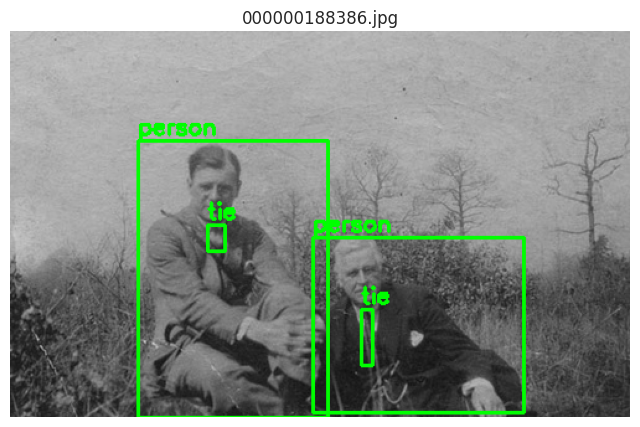

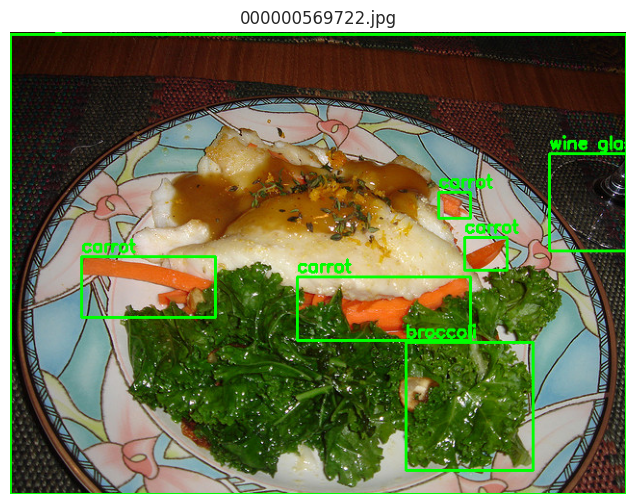

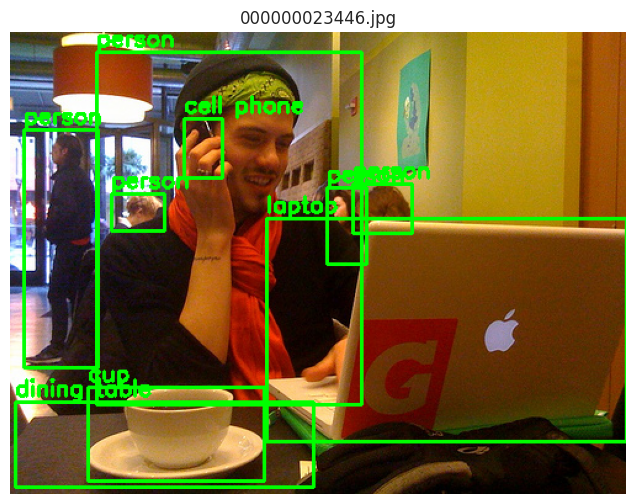

In [6]:
# Utility to draw YOLO boxes
def draw_yolo_bbox(img_path, label_path):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    with open(label_path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls_id = int(parts[0])
            x_center, y_center, bw, bh = map(float, parts[1:5])
            
            # Convert YOLO normalized coords to pixels
            x1 = int((x_center - bw/2) * w)
            y1 = int((y_center - bh/2) * h)
            x2 = int((x_center + bw/2) * w)
            y2 = int((y_center + bh/2) * h)
            
            color = (0, 255, 0)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img, classes[cls_id], (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Pick a few random images
sample_images = random.sample(glob(os.path.join(IMAGES_DIR, "**", "*.jpg"), recursive=True), 5)

for img_path in sample_images:
    label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
    if os.path.exists(label_path):
        img = draw_yolo_bbox(img_path, label_path)
        plt.figure(figsize=(8,6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(img_path))
        plt.show()


5.Co-occurrence matrix for top classes

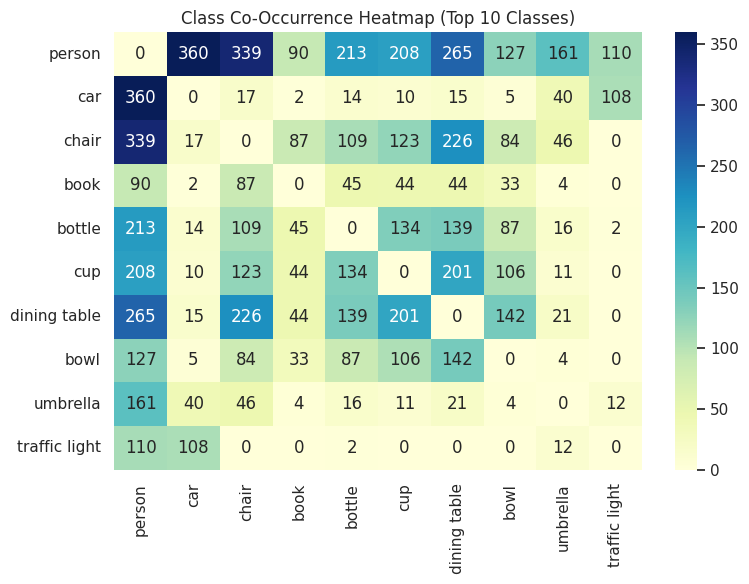

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np

# Limit to top N classes
top_n = 10
top_classes = df["class_name"].value_counts().head(top_n).index.tolist()

# Create co-occurrence matrix for top classes only
image_to_classes = df[df["class_name"].isin(top_classes)].groupby("file")["class_name"].unique()
matrix = pd.DataFrame(0, index=top_classes, columns=top_classes)

for class_list in image_to_classes:
    for a, b in combinations(class_list, 2):
        matrix.loc[a, b] += 1
        matrix.loc[b, a] += 1

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, cmap="YlGnBu", annot=True, fmt="d", xticklabels=True, yticklabels=True)
plt.title(f"Class Co-Occurrence Heatmap (Top {top_n} Classes)")
plt.tight_layout()
plt.show()

6.Object Size vs Frequency (tiny vs large objects)

This shows whether your dataset is dominated by small or large bounding boxes — critical for YOLO performance.

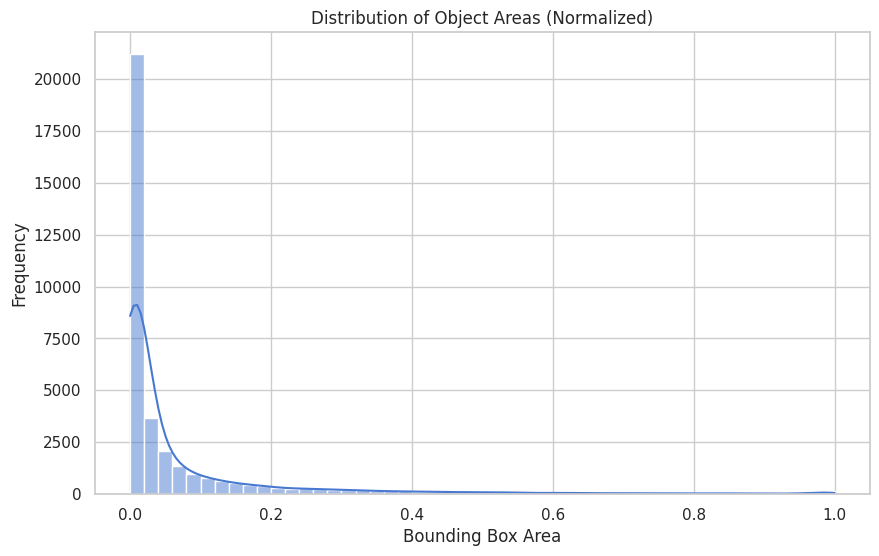

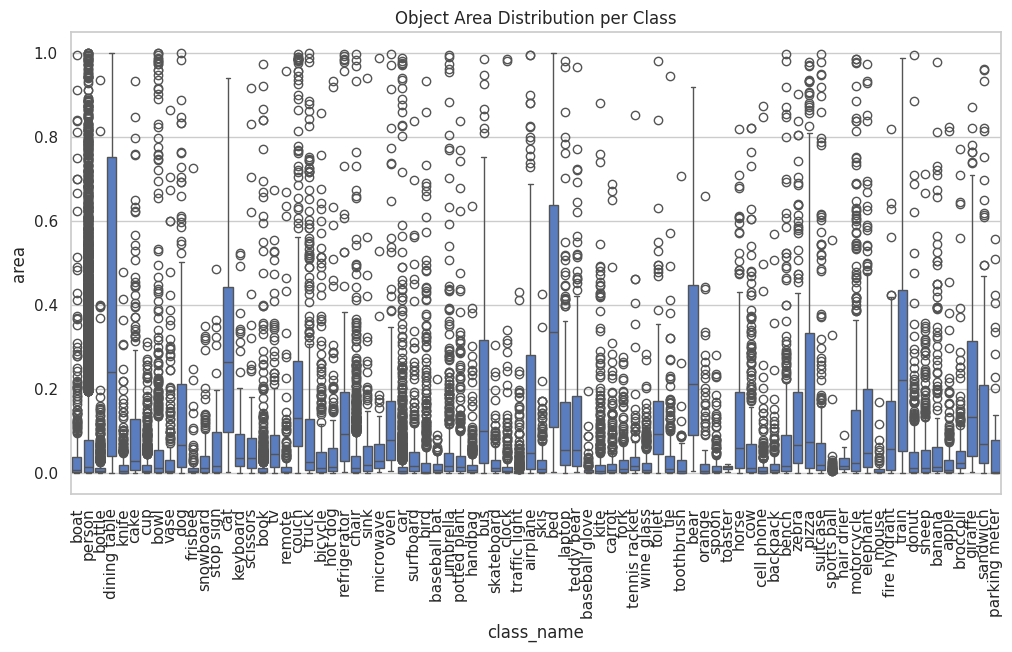

In [8]:
df["area"] = df["width"] * df["height"]

plt.figure(figsize=(10,6))
sns.histplot(df["area"], bins=50, kde=True)
plt.title("Distribution of Object Areas (Normalized)")
plt.xlabel("Bounding Box Area")
plt.ylabel("Frequency")
plt.show()

# Group by class
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="class_name", y="area")
plt.xticks(rotation=90)
plt.title("Object Area Distribution per Class")
plt.show()


7.Spatial Distribution Heatmaps (Where objects appear in images)

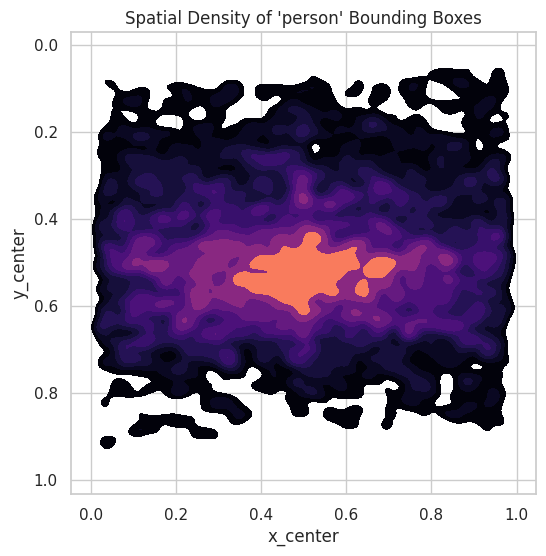

In [9]:
import numpy as np

# Choose a class, e.g. "person"
target_class = "person"
coords = df[df["class_name"] == target_class][["x_center", "y_center"]].values

plt.figure(figsize=(6,6))
sns.kdeplot(
    x=coords[:,0], y=coords[:,1],
    fill=True, cmap="magma", bw_adjust=0.3, thresh=0.1
)
plt.title(f"Spatial Density of '{target_class}' Bounding Boxes")
plt.xlabel("x_center")
plt.ylabel("y_center")
plt.gca().invert_yaxis()
plt.show()


In [10]:
print("====== Dataset Summary ======")
print(f"Total images: {len(label_files)}")
print(f"Total annotated objects: {len(df)}")
print(f"Number of unique classes: {num_classes}")
print(f"Average objects per image: {objects_per_image.mean():.2f}")
print(f"Average image size: {res_df['width'].mean():.0f}x{res_df['height'].mean():.0f}")


====== Dataset Summary ======
Total images: 4955
Total annotated objects: 36180
Number of unique classes: 80
Average objects per image: 7.30


NameError: name 'res_df' is not defined